In [1]:
import pymodels as pm
import pyaccel as pa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from generic_scripts import nlk
from mathphys.beam_optics import beam_rigidity
from scipy.optimize import minimize

In [2]:
# plt.style.use(['notebook'])
plt.style.use(['science', 'notebook'])
plt.rcParams.update({
    'font.size': 18, 'lines.linewidth': 2,
    'axes.grid': False, 'grid.alpha': 0.5, 'grid.linestyle': '--',
    'text.usetex': True})

In [3]:
fig_path = r'/home/jucelio/notebooks/figures/TS_effects_on_exchange/'

# Useful functions

In [4]:
def compute_emittances(bunch, local_twiss):
    """."""
    twiss = local_twiss
    etax, etapx = twiss.etax, twiss.etapx
    etay, etapy = twiss.etay, twiss.etapy
    disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])
    bunch_nodisp = bunch - bunch[4]*disp
    emitx = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[0:2, :])))
    emity = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4, :])))
    
    return emitx, emity

In [5]:
def plot_phases_diagrams(bunch, bunch_ex, emitx, emity, emitx_ex, emity_ex, title=""):
    fig, ax = plt.subplots(1,2, figsize = (11,6), sharex=False, sharey=False)
#     fig, ax = plt.subplots(1,2, sharex=False, sharey=False) 
    x, x_ = bunch[0, :]*1e3, bunch[1, :]*1e3
    y, y_ = bunch[2, :]*1e3, bunch[3, :]*1e3
    x_ex, x__ex = bunch_ex[0, :]*1e3, bunch_ex[1, :]*1e3
    y_ex, y__ex = bunch_ex[2, :]*1e3, bunch_ex[3, :]*1e3

    ax[0].scatter(x, x_, s=4, label=r'$\epsilon_x = {:.3f} \; nm$'.format(emitx*1e9), alpha=1, color='tab:blue')
    ax[0].scatter(x_ex, x__ex, s=4, label=r'$\epsilon_x$ (exc.) $= {:.3f} \; nm$'.format(emitx_ex*1e9), 
                  color='tab:red', alpha=1)

    ax[1].scatter(y_ex, y__ex, s=4, label=r'$\epsilon_y$ (exc.) $= {:.3f} \; nm$'.format(emity_ex*1e9),
                  color='tab:red', alpha=1)
    ax[1].scatter(y, y_, s=4, label=r'$\epsilon_y = {:.2f} \; nm$'.format(emity*1e9), alpha=1, color='tab:blue')


    fig.suptitle(title, fontsize=16)
    ax[0].set_xlabel('x [mm]')
    ax[0].set_ylabel("x' [mrad]")
    ax[1].set_xlabel('y [mm]')
    ax[1].set_ylabel("y' [mrad]")
    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
#     plt.tight_layout()
#     plt.savefig(fname,dpi=160)
    return fig, ax
    #     plt.show()

In [6]:
def error_func(bunch_in, gain, poly_b, nlk):
    """."""
    nlk_c = nlk[:]
    bunch_c = bunch_in.copy()
    nlk_l = nlk.length
    poly_b_c = poly_b.copy()
    # Setting NLK for the beam aways be in x'= 0 after the kick
    nlk_c[0].polynom_b = gain*poly_b_c
#     print(f"Setted polynom_b: \n {nlk_c[0].polynom_b}")
    # Tracking beam through NLK
    part_out_ex, *_ = pa.tracking.line_pass(nlk_c,
                                            bunch_c, indices='closed',
                                            parallel=True)
    if bunch.ndim < 3:
        bunch_final = part_out_ex[:,-1]
    else:
        bunch_final = part_out_ex[:,:,-1]
    x__ = bunch_final[1].mean()
    return np.abs(x__)

# Bunch at Booster end - TS beginning

In [7]:
# Creating a booster with small coupling
bo = pm.bo.create_accelerator(energy=3e9)
bo_famdata = pm.bo.get_family_data(bo)
bo.radiation_on = True
bo.vchamber_on = True
bo.cavity_on = True
KsL = -0.00365
qs_idx = bo_famdata['QS']['index']
bo[qs_idx[0][0]].KsL = KsL

# Creating the TS line
ts, ts_init_twiss = pm.ts.create_accelerator(
                    optics_mode="M2")  # Maybe is better change to "M2"
ts.radiation_on = True
ts.vchamber_on = True

In [8]:
ed_tend, _ = pa.optics.calc_edwards_teng(bo)
c, emit_ratio = pa.optics.estimate_coupling_parameters(ed_tend)

Creating the bunch

In [9]:
bo_eqparam = pa.optics.EqParamsFromBeamEnvelope(accelerator=bo)
emit1 = bo_eqparam.emit1
emit2 = bo_eqparam.emit2
sigme = bo_eqparam.espread0
sigmal = bo_eqparam.bunlen
n_part = 2000

# Supposing a emittance exchange with R=0.95
R = 0.95
deltaemit = emit1-emit2
emit1_ex = emit1 - deltaemit*R
emit2_ex = emit2 + deltaemit*R

bunch = pa.tracking.generate_bunch(n_part=n_part, emit1=emit1, emit2=emit2, 
                                   sigmae=sigme, sigmas=sigmal, optics=ts_init_twiss)
bunch_ex = pa.tracking.generate_bunch(n_part=n_part, emit1=emit1_ex, emit2=emit2_ex, 
                                   sigmae=sigme, sigmas=sigmal, optics=ts_init_twiss)

Computing emittances

In [10]:
# Shifting the bunch to the TS orbit
# centroid_at_ts =  np.array([2.73724778e-03,  4.25220469e-04, -7.24359070e-21,  3.19401356e-21,
#  -7.96083635e-05, -8.05961219e-02])
centroid_at_ts = np.array([0,0,0,0,0,0])
bunch = bunch + centroid_at_ts[:, None]
bunch_ex = bunch_ex + centroid_at_ts[:, None]

emitx, emity = compute_emittances(bunch, ts_init_twiss)
emitx_ex, emity_ex = compute_emittances(bunch_ex, ts_init_twiss)

Phase diagram

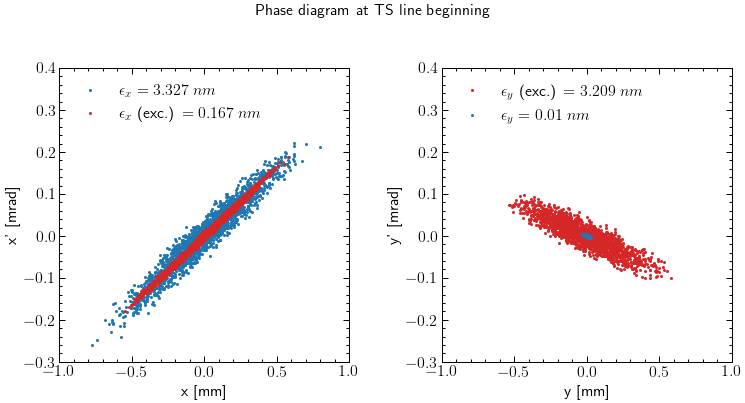

In [11]:
fname =  fname=fig_path+"before_ts.pdf"

fig, ax = plot_phases_diagrams(
    bunch, bunch_ex, emitx, emity,
    emitx_ex, emity_ex, title='Phase diagram at TS line beginning')

# fig, ax = plot_phases_diagrams(
#     bunch, bunch_ex, emitx, emity,
#     emitx_ex, emity_ex)

ax[0].sharex(ax[1])
ax[0].sharey(ax[1])
ax[0].set_xlim([-1, 1])
ax[0].set_ylim([-0.3, 0.4])
fig.tight_layout(pad=1.5)
plt.savefig(fname,facecolor='white', transparent=False, dpi=150)
plt.show()

Beam in horizontal and vertical coordinates

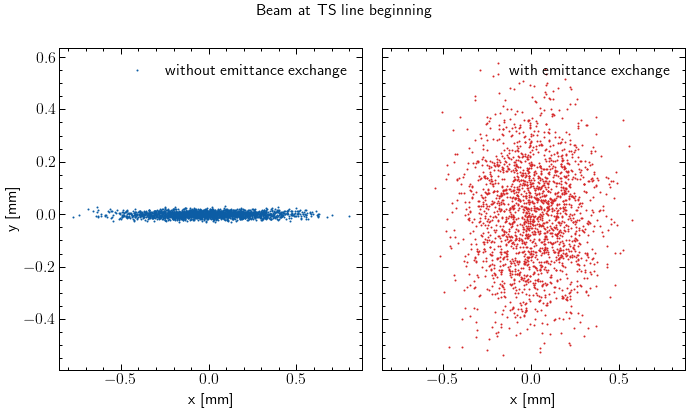

In [12]:
x, y = bunch[0, :], bunch[2, :]
x_ex, y_ex = bunch_ex[0, :], bunch_ex[2, :]

fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=True, sharey=True)
fig.suptitle('Beam at TS line beginning', fontsize=16)

ax[0].scatter(x*1e3, y*1e3, label = 'without emittance exchange', s=1)
ax[1].scatter(x_ex*1e3, y_ex*1e3, color='tab:red', label='with emittance exchange', s=1)

ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[1].set_xlabel('x [mm]')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
# plt.savefig("figures/emit_exchange_studies/beam_size_before.png", facecolor='white', transparent=False, dpi=160)

# TS Tracking

In [13]:
# Passing through TS
part_out, lost_flag, *_ = pa.tracking.line_pass(
            ts, bunch, indices='closed'
            )
part_out_ex, lost_flag_ex, *_ = pa.tracking.line_pass(
            ts, bunch_ex, indices='closed'
            )

## Getting beam information on TS screens

In [14]:
screens_indices = pa.lattice.find_indices(ts, 'fam_name','Scrn')

In [15]:
part_at_screens = part_out_ex[:, :, screens_indices]

In [16]:
s_number = part_at_screens.shape[2]
scr_data = np.zeros([s_number, 5])
indices =  ("TS-01:DI-Scrn",
            "TS-02:DI-Scrn",
            "TS-03:DI-Scrn",
            "TS-04:DI-Scrn-1",
            "TS-04:DI-Scrn-2",
            "TS-04:DI-Scrn-3")

scr_data ={'scr_idx': indices}
scr_data["sigma_x"] = np.zeros(s_number)
scr_data["sigma_x'"] = np.zeros(s_number)
scr_data["sigma_y"] = np.zeros(s_number)
scr_data["sigma_y'"] = np.zeros(s_number)

for i in range(s_number):
    x_cov = np.cov(part_at_screens[0, :, i])
    x__cov = np.cov(part_at_screens[1, :, i])
    y_cov = np.cov(part_at_screens[2, :, i])
    y__cov = np.cov(part_at_screens[3, :, i])
    scr_data["sigma_x"][i] = np.sqrt(x_cov)*1e3
    scr_data["sigma_x'"][i] = np.sqrt(x__cov)*1e3
    scr_data["sigma_y"][i] = np.sqrt(y_cov)*1e3
    scr_data["sigma_y'"][i] = np.sqrt(y__cov)*1e3

In [17]:
data_df = pd.DataFrame(scr_data)
data_df.columns = ['scr_name', 'sigma_x [mm]', "sigma_x'[mrad]", 'sigma_y [mm]', "sigma_y' [mrad]"]

In [18]:
data_df

,scr_name,sigma_x [mm],sigma_x'[mrad],sigma_y [mm],sigma_y' [mrad]
0,TS-01:DI-Scrn,0.128586,0.078165,0.148896,0.029849
1,TS-02:DI-Scrn,0.217666,0.055291,0.225120,0.086812
2,TS-03:DI-Scrn,0.473994,0.128877,0.158342,0.021802
3,TS-04:DI-Scrn-1,0.492757,0.108422,0.196748,0.077425
4,TS-04:DI-Scrn-2,0.277000,0.159163,0.159933,0.028602
5,TS-04:DI-Scrn-3,0.044595,0.006264,0.114421,0.029934


In [19]:
data_df.to_csv('second_moments_ts.txt', sep='\t', index=False)

In [20]:
ts_bunchs = part_out_ex[:, :, screens_indices]

In [21]:
energy_spread = np.std(ts_bunchs[4, :,:], axis=0)

In [22]:
energy_spread

array([0.00088568, 0.00088567, 0.00088567, 0.00088566, 0.00088566,
       0.00088565])

## Analysis on TS end

In [23]:
bunch_end = part_out[:, :, -1]
bunch_ex_end = part_out_ex[:, :, -1]

Computing emittances at the end of TS line

In [24]:
twi, *_ = pa.optics.calc_twiss(accelerator=ts, init_twiss=ts_init_twiss)
twiss = twi[-1]
# Without emittance exchange
emitx, emity =compute_emittances(bunch_end, twiss)
# With emittance exchange
emit1_ex, emit2_ex = compute_emittances(bunch_ex_end, twiss)

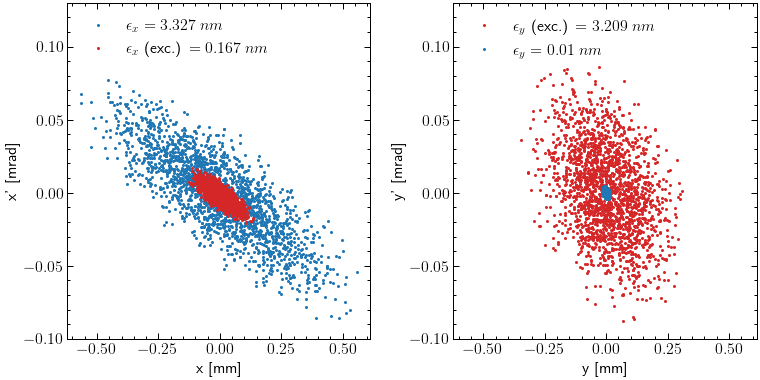

In [25]:
# fname = fig_path + "after_ts.png"
# fig, ax = plot_phases_diagrams(bunch_end, bunch_ex_end, emitx, emity,
#                     emitx_ex, emity_ex, title='Phase diagram at the end of TS line')

fname = fig_path + "after_ts.pdf"
fig, ax = plot_phases_diagrams(bunch_end, bunch_ex_end, emitx, emity,
                    emitx_ex, emity_ex)

ax[0].sharex(ax[1])
ax[0].sharey(ax[1])
# ax[0].set_xlim([-1, 1])
ax[0].set_ylim([-0.1, 0.13])
fig.tight_layout(pad=1.5)
plt.tight_layout()
plt.savefig(fname, facecolor='white', transparent=False, dpi=150)
plt.show()

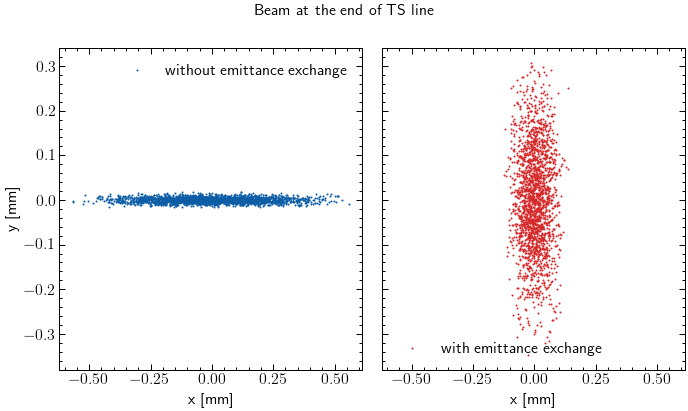

In [26]:
x, y = bunch_end[0, :], bunch_end[2, :]
x_ex, y_ex = bunch_ex_end[0, :], bunch_ex_end[2, :]

fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=True, sharey=True)
fig.suptitle('Beam at the end of TS line ', fontsize=16)

ax[0].scatter(x*1e3, y*1e3, s=1, label = 'without emittance exchange')
ax[1].scatter(x_ex*1e3, y_ex*1e3, s=1, color='tab:red', label='with emittance exchange')
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[1].set_xlabel('x [mm]')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig("beam_after.jpg", dpi=160)

# NLK effect on the exchanged beam

Testing NLK

## Transporting the beam until nlk

Creating Sirius, getting family data and changing the bunch reference frame

In [27]:
si = pm.si.create_accelerator()
si.cavity_on = True
si.radiation_on = True
si.vchamber_on = True

twi, _ = pa.optics.calc_twiss(si)
famdata = pm.si.get_family_data(si)
nlk_idx = famdata['InjNLKckr']['index']
sept_idx = pa.lattice.find_indices(
            lattice=si, attribute_name='fam_name', value='InjSeptF')
# offset = np.array([-17.35e-3, 2.4e-3, 0, 0, 0, 0])[:, None]

bunch_sept = bunch_end - bunch_end.mean(axis=1)[:, None] #+ offset
bunchex_sept = bunch_ex_end - bunch_end.mean(axis=1)[:, None] #+  offset

Tracking from Septa to NLK 

In [28]:
bunch_sep, *_ = pa.tracking.line_pass(
    si, particles=bunch_sept, indices=nlk_idx[0], element_offset=sept_idx[0], parallel=True)

bunchex_sep, *_ = pa.tracking.line_pass(
    si, particles=bunchex_sept, indices=nlk_idx[0], element_offset=sept_idx[0], parallel=True)

emitx, emity = compute_emittances(bunch_sep, twi[nlk_idx[0][0]])
emitx_ex, emity_ex = compute_emittances(bunchex_sep, twi[nlk_idx[0][0]])

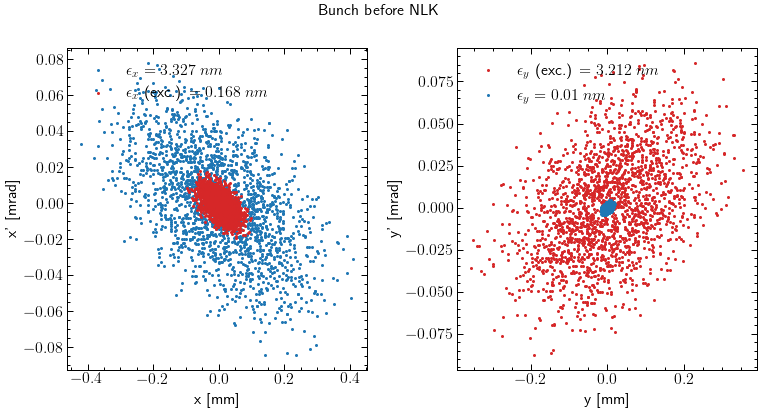

In [29]:
fig, ax = plot_phases_diagrams(
            bunch_sep, bunchex_sep, emitx, emity, 
            emitx_ex, emity_ex, title='Bunch before NLK')
plt.tight_layout()
plt.show()

In [30]:
sx, sy = bunch_sep[0, :].std(), bunch_sep[2, :].std()
sx_ex, sy_ex = bunchex_sep[0, :].std(), bunchex_sep[2, :].std()

print(f'Beam sizes: \n No TEE: sigx = {sx:.2e}, sigy = {sy:.2e} \n With TEE: sigx = {sx_ex:.2e}, sigy = {sy_ex:.2e}')

Beam sizes: 
 No TEE: sigx = 1.40e-04, sigy = 6.17e-06 
 With TEE: sigx = 3.17e-05, sigy = 1.18e-04


In [31]:
bunch_sep[0].max() - bunch_sep[0].min()

0.0008301107187974493

In [32]:
si.length-twi.spos[sept_idx[0]]+twi.spos[nlk_idx[0][0]]

3.654779999999971

In [33]:
transp_matrix = np.array([[1, 3.6547],[0, 1]])
x_coords = transp_matrix @ bunch_sept[:2]

In [34]:
np.std(x_coords[0])

0.00013097167956054932

In [35]:
print(si[sept_idx[0]]), nlk_idx[0]

fam_name   : InjSeptF 
pass_method: identity_pass 
vchamber   : 2 
hmin       : -0.012 m
hmax       : 0.012 m
vmin       : -0.012 m
vmax       : 0.012 m


(None, [11])

## Kicking the beam

Putting the bunch at NLK based on offset values available on Wiki-Sirius

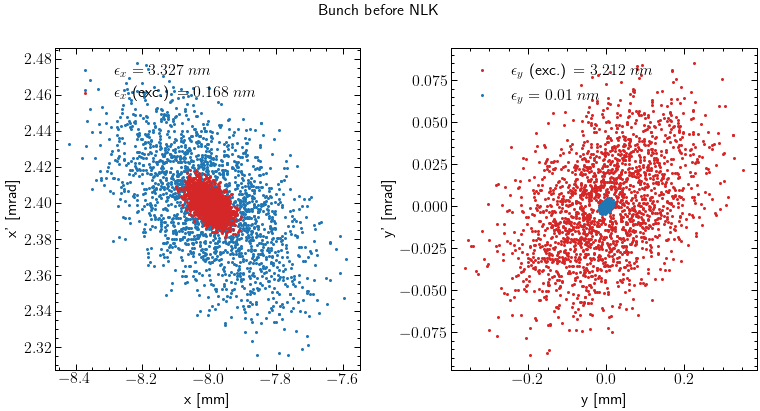

In [36]:
nlk_b_offset = np.array([-8e-3, 2.4e-3, 0, 0, 0, 0])[:, None] # Bunch offset at NLK
bunch_nlk = bunch_sep + nlk_b_offset - bunch_sep.mean(axis=1)[:, None]
bunchex_nlk = bunchex_sep + nlk_b_offset - bunchex_sep.mean(axis=1)[:, None]

fig, ax = plot_phases_diagrams(
            bunch_nlk, bunchex_nlk, emitx, emity, 
            emitx_ex, emity_ex, title='Bunch before NLK')
plt.tight_layout()
plt.show()

Loading the nlk profile

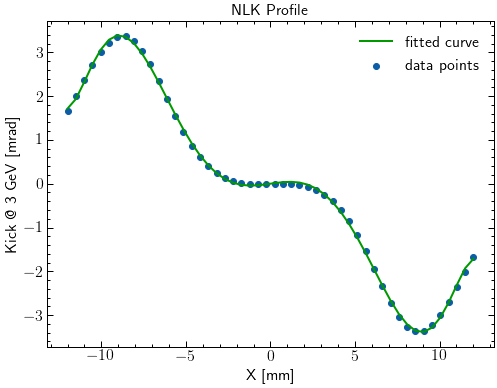

In [37]:
monomials = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])[None, :]
nlk_obj = nlk.NLK()

nlk_x, integ_field, kickx, poly_b = nlk.NLK.si_nlk_kick(plot_flag=True, scale=1)

plt.show()

Minimizing x' with scipy using k as parameter

In [38]:
nlk_si = si[nlk_idx[0][0]:nlk_idx[0][0]+1][:]
fun = lambda k: error_func(bunch_in=bunchex_nlk, gain=k, poly_b=poly_b, nlk=nlk_si)
res = minimize(fun, -1, tol=1e-6)

In [39]:
## Fitting log
res

      fun: 8.540941825313508e-12
 hess_inv: array([[502.4003496]])
      jac: array([0.00049441])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 86
      nit: 1
     njev: 37
   status: 2
  success: False
        x: array([-1.54769161])

Setting the NLK pulse

In [40]:
nlk_si[0].polynom_b = res.x[0]*poly_b/1.8
print(nlk_si[0].polynom_b)

[ 8.54649438e-18  1.06105014e-01 -1.00123663e-12 -2.65798282e+04
  2.83428275e-08  1.81394485e+08 -2.88500893e-04  7.26322516e+11
  1.00377720e+00 -5.77234433e+15]


Bunch after NLK

In [41]:
part_out, *_ = pa.tracking.line_pass(nlk_si, bunch_nlk, indices='closed', parallel=True)

part_out_ex, *_ = pa.tracking.line_pass(nlk_si, bunchex_nlk, indices='closed', parallel=True)

bunch_final = part_out[:,:,-1]
bunchex_final = part_out_ex[:,:,-1]

# Emittances after NLK
si_twi, _ = pa.optics.calc_twiss(si, indices=[nlk_idx[0][0]+1])
emitx, emity = compute_emittances(bunch_final, si_twi[0])
emitx_ex, emity_ex = compute_emittances(bunchex_final, si_twi[0])

In [42]:
bunchex_final.mean(axis=1)

array([-7.51014496e-03, -1.85595966e-04, -6.80609990e-09, -2.80914542e-08,
       -5.65387210e-09,  3.91491619e-07])

Disable NLK

In [43]:
si[nlk_idx[0][0]].polynom_b = np.zeros([7])

Computing acceptances

In [44]:
si.radiation_on = False
# particle = np.array([-7.5e-3, 0, 0, 0, 0, 0])[:, None]
# particle2 = np.array([-8e-3, 0, 0, 0, 0, 0])[:, None]
particle3 = np.array([-8.5e-3, 0, 0, 0, 0, 0])[:, None]
particle4 = np.array([-9.5e-3, 0, 0, 0, 0, 0])[:, None]
# particles = np.array([particle, particle2, particle3, particle4])[:,:, 0].T
particles = particle3

design_apert, *_ = pa.tracking.ringpass(
    si, particle4, parallel=True, nr_turns = 2000, 
    turn_by_turn=True)

apert, *_ = pa.tracking.ringpass(
    si, particles, parallel=True, nr_turns = 2000, 
    turn_by_turn=True)

si.radiation_on = True

Plotting bunch with acceptances

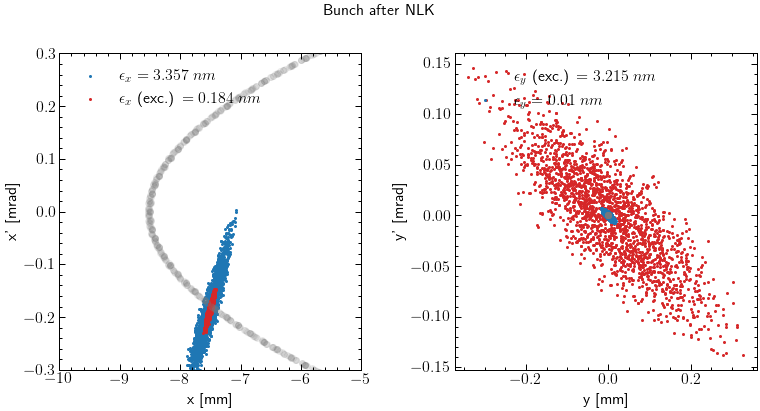

In [45]:
fig, ax = plot_phases_diagrams(
            bunch_final, bunchex_final, emitx, emity, 
            emitx_ex, emity_ex, title='Bunch after NLK')
ax[0].scatter(apert[0]*1e3, apert[1]*1e3, alpha=0.1, c='tab:gray')
ax[1].scatter(apert[2]*1e3, apert[3]*1e3, alpha=0.1, c='tab:gray')

ax[0].set_xlim([-10, -5])
ax[0].set_ylim([-0.3, 0.3])
plt.tight_layout()
plt.show()

## Testing different initial offsets at NLK beginning

Creating bunchs in different positions at NLK

In [46]:
nlk_id = nlk_idx[0][0]
x_list = np.linspace(-8.5, -7,num=4)*1e-3
bunchs_before = np.zeros([x_list.size, 6, n_part])
bunchs_after = bunchs_before.copy()
bunchsex_before = np.zeros([x_list.size, 6, n_part])
bunchsex_after = bunchs_before.copy()

for n in range(bunchs_before.shape[0]):
    bunchs_before[n] = bunch_nlk.copy()
    bunchs_before[n][0] += -bunchs_before[n][0].mean() + x_list[n]
    
    bunchsex_before[n] = bunchex_nlk.copy()
    bunchsex_before[n][0] += -bunchsex_before[n][0].mean() + x_list[n]

Optimizing the NLK using macroparticles

In [47]:
ks = np.zeros(x_list.size)
for j in range(len(ks)):
    macro_part = np.mean(bunchsex_before[j], axis=1, keepdims=True)
#     print(macro_part)
    fun = lambda k: error_func(macro_part, k, poly_b, nlk=nlk_si)
    res = minimize(fun, -1, tol=1e-9)
    k = res.x[0]
    ks[j] = k

In [48]:
ks_normalized = ks/ks[1]
ks_normalized

array([0.92852025, 1.        , 1.11287508, 1.27947455])

Tracking the different bunchs with the best k for which one.

In [49]:
nlk_si = si[nlk_id:nlk_id+1]

# Tracking beam through NLK
for i in range(bunchs_after.shape[0]):
    # Setting nlk
    nlk_si[0].polynom_b = ks[i]*poly_b
    
    #Tracking
    bunch = bunchs_before[i].copy()
    bunchex = bunchsex_before[i].copy()
    part_out, *_ = pa.tracking.line_pass(nlk_si, 
                                         bunch, indices='closed',
                                         parallel=True)
    part_out_ex, *_ = pa.tracking.line_pass(nlk_si,
                                            bunchex, indices='closed',
                                            parallel=True)
    bunchs_after[i] = part_out[:,:,-1]
    bunchsex_after[i] = part_out_ex[:,:,-1]

Plotting the results

In [50]:
np.max(kickx*ks[-1])

0.00345127681050629

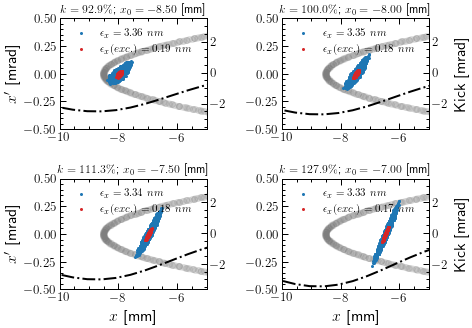

In [51]:
# with plt.style.context(['science']):
## Adds grid
fig, ax = plt.subplots(2, 2, figsize=(7,5))

k, j= 0,0
for i in range(4):
    if i==2:
        k=1
        j=0
    
    bunch = bunchs_after[i]
    bunchex = bunchsex_after[i]
    x_0 = bunchs_before[i, 0, :].mean()
#     y_0 = bunchs_before[i, 2, :].mean()
    emitx, emity = compute_emittances(bunch, twi[nlk_idx[0][0]+1])
    emitx_ex, emity_ex = compute_emittances(bunchex, twi[nlk_idx[0][0]+1])
    
    #Ploting the NLK curve
    ax2 = ax[k][j].twinx()
    ax2.plot(nlk_x*1e3, ks[i]*kickx*1e3, ls='-.', c='k', label = 'NLK kick')
#     ax2.tick_params(axis='y', labelcolor=)
    ax2.set_ylim([-3.65, 3.5])
    if j == 1:
        ax2.set_ylabel("Kick [mrad]")
    
#     #Ploting bunch before the kick
#     ax[k][j].scatter(bunchs_before[i, 0, :]*1e3, bunchs_before[i, 1, :]*1e3)
#     ax[k][j].scatter(bunchsex_before[i, 0, :]*1e3, bunchsex_before[i, 1, :]*1e3)
        
    # Plotting the results
    ax[k][j].scatter(apert[0]*1e3, apert[1]*1e3, alpha=0.05, c='tab:gray')
#     ax[k][j].set_xlim([-9, -6])
#     ax[k][j].set_ylim([-1, 2.6])
    ax[k][j].set_xlim([-10, -5])
    ax[k][j].set_ylim([-0.5, 0.5])


    x, x_ = bunch[0, :]*1e3, bunch[1, :]*1e3
    x_ex, x__ex = bunchex[0, :]*1e3, bunchex[1, :]*1e3

    ax[k][j].scatter(x, x_, s=4, label=r'$\epsilon_x = {:.2f} \; nm$'.format(emitx*1e9), alpha=1, color='tab:blue')
    ax[k][j].scatter(x_ex, x__ex, s=4, label=r'$\epsilon_x (exc.) = {:.2f} \; nm$'.format(emitx_ex*1e9), 
                  color='tab:red', alpha=1)

    ax[k][j].legend(loc='upper left', fontsize='11')
    ax[k][j].set_title(f'$k = {ks_normalized[i]*100:.1f} \%$; $x_0 = {x_0*1e3:.2f}$ [mm]', fontsize=12)
    ax[k][j].tick_params(labelsize=13)
    ax2.tick_params(labelsize=13)
    j+=1
ax[0][0].set_ylabel("$x'$ [mrad]")
ax[1][0].set_ylabel("$x'$ [mrad]")
ax[1][0].set_xlabel('$x$ [mm]')
ax[1][1].set_xlabel('$x$ [mm]')
# fig.suptitle("NLK effect in the beam with different initial horizontal positions", fontsize=18, y=1)
plt.tight_layout()
# plt.savefig('/home/jucelio/notebooks/figures/TS_effects_on_exchange/NLK_effect.png', facecolor='white', transparent=False, dpi=300)
plt.savefig('/home/jucelio/notebooks/figures/TS_effects_on_exchange/NLK_effect.pdf')

In [52]:
x_list

array([-0.0085, -0.008 , -0.0075, -0.007 ])

Making a new figure

(-1.0, 3.0)

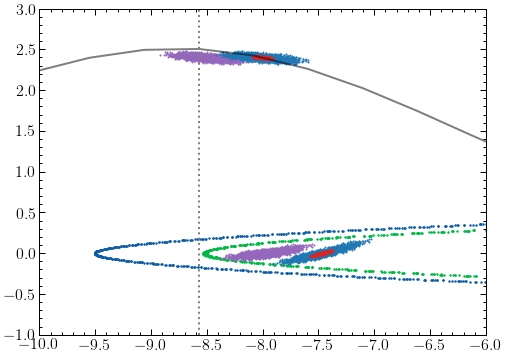

In [53]:
fig, ax = plt.subplots()

ax.plot(nlk_x*1e3, -ks[0]*kickx*1e3, ls='-', c='k', label = 'NLK kick', alpha=0.5)
ax.axvline(nlk_x[np.argmax(kickx)]*1e3, ls='dotted', c='tab:gray')

ax.scatter(design_apert[0, :]*1e3, design_apert[1, :]*1e3, s=2)
ax.scatter(apert[0, :]*1e3, apert[1, :]*1e3, s=2)

ax.scatter(bunchs_before[0, 0, :]*1e3, bunchs_before[0, 1, :]*1e3, s=1, c='tab:purple')
ax.scatter(bunchs_before[1, 0, :]*1e3, bunchs_before[1, 1, :]*1e3, s=1, c='tab:blue')
# ax.scatter(bunchsex_before[0, 0, :]*1e3, bunchs_before[0, 1, :]*1e3, s=1, c='')
ax.scatter(bunchsex_before[1, 0, :]*1e3, bunchsex_before[1, 1, :]*1e3, s=1, c='tab:red')

ax.scatter(bunchs_after[0, 0, :]*1e3, bunchs_after[0, 1, :]*1e3, s=1, c='tab:purple')
ax.scatter(bunchs_after[1, 0, :]*1e3, bunchs_after[1, 1, :]*1e3, s=1, c='tab:blue')
# ax.scatter(bunchsex_after[0, 0, :]*1e3, bunchs_after[0, 1, :]*1e3, s=1)
ax.scatter(bunchsex_after[1, 0, :]*1e3, bunchsex_after[1, 1, :]*1e3, s=1, c='tab:red')



ax.set_xlim([-10,-6])
ax.set_ylim([-1,3])

In [54]:
design_apert


array([[-9.50000000e-03, -7.68291431e-03, -4.12961944e-03, ...,
         6.84290690e-03,  3.80952971e-03, -3.42372703e-04],
       [ 0.00000000e+00,  2.49177363e-04,  4.49033370e-04, ...,
        -3.45577306e-04, -5.15315576e-04, -5.38018201e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.96206831e-08, -1.52727230e-08, ...,
         2.03571867e-05,  2.09046191e-05,  2.14097533e-05],
       [ 0.00000000e+00,  4.28999461e-05,  3.98561845e-05, ...,
        -2.30469207e-06, -6.21376122e-06, -5.05248036e-05]])

In [58]:
x = np.linspace(0.1,6)
y = np.exp(-np.pi**2/x)

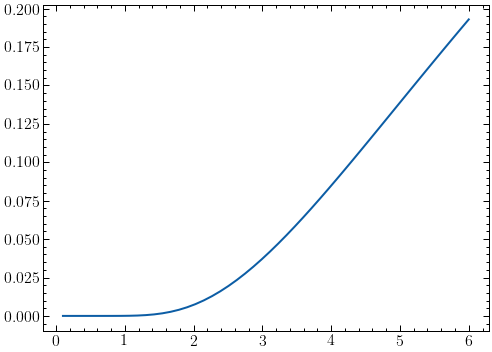

In [59]:
plt.plot(x, y)